In [1]:
from IPython.display import Image


## Purpose :
#### Predict NYC Taxi trip duration in `RMSLE` metric ( Root Mean Squared Logarithmic Error) 

- https://www.kaggle.com/c/nyc-taxi-trip-duration#evaluation



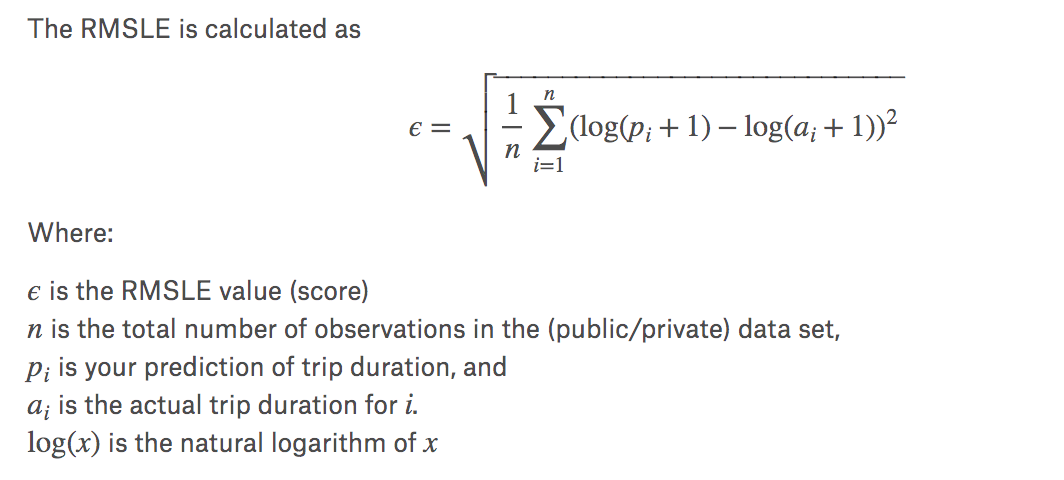

In [2]:
Image(filename='../NYC_Taxi_Trip_Duration/documents/RMSLE.png') 


## Process : 
    - 0 FEATURE ENGINEERING 
    - 0'DATA CLEANING 
    - 1 SIMPLE MODELING 
        -1.1 linear regression
        -1.2 lasso regression
        -1.3 decision tree regression
        -1.4 random forest regression 
        -1.5 xgboost
        -1.x logistic regression ***
    - 2 SELECT MODELS 
        -2.1 parameter select 
        -2.2 model tuning
    - 3 PREDICTION ENSEMBLE 

In [3]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
from IPython.display import Image 

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load data

df_train = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/train.csv')
df_test = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/test.csv')
sampleSubmission = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/sample_submission.csv')

In [5]:
# basic feature extract 

def basic_feature_extract(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # dropoff 
    df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
    df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    return df_


# get weekday
import calendar
def get_weekday(df):
    list(calendar.day_name)
    df_=df.copy()
    df_['pickup_week_'] = pd.to_datetime(df_train.pickup_datetime,coerce=True).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    return df_

# get trip duration 
def get_duration(df):
    df_= df.copy()
    df_['trip_duration_cal'] = pd.to_datetime(df_['dropoff_datetime']) - pd.to_datetime(df_['pickup_datetime'])
    return df_
    



In [6]:
df_train_ = basic_feature_extract(df_train)

In [7]:
df_train_ = get_duration(df_train_)

In [8]:
df_train_ = get_weekday(df_train_)

//anaconda/envs/g_dash/lib/python3.4/site-packages/ipykernel_launcher.py:25: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


In [9]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_month,pickup_weekday,dropoff_date,dropoff_hour,dropoff_year,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,2016-03-14,17,2016,03,0,00:07:35,0,Monday


## 0) Feature engineering 

In [10]:
# feature extract

###  distance 
# https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-377?scriptVersionId=1369021

# Haversine distance
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

# Manhattan distance
# Taxi cant fly ! have to move in blocks/roads
def get_manhattan_distance(lat1, lng1, lat2, lng2):
    # km 
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


# get direction (arc tangent angle)
def get_direction(lat1, lng1, lat2, lng2):
    # theta
    AVG_EARTH_RADIUS = 6371  #  km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))



### ======================== ###

def get_features(df):
    # km 
    df_ = df.copy()
    ###  USING .loc making return array ordering 
    # distance
    df_.loc[:, 'distance_haversine'] = get_haversine_distance(
                      df_['pickup_latitude'].values,
                      df_['pickup_longitude'].values,
                      df_['dropoff_latitude'].values,
                      df_['dropoff_longitude'].values)
    df_.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                      df_['pickup_latitude'].values,
                      df_['pickup_longitude'].values,
                      df_['dropoff_latitude'].values,
                      df_['dropoff_longitude'].values)
    # direction 
    df_.loc[:, 'direction'] = get_direction(df_['pickup_latitude'].values,
                                          df_['pickup_longitude'].values, 
                                          df_['dropoff_latitude'].values, 
                                          df_['dropoff_longitude'].values)
    # Get Average driving speed 
    # km/hr
    # (km/sec = 3600 * (km/hr))
    df_.loc[:, 'avg_speed_h'] = 3600 * df_['distance_haversine'] / df_['trip_duration']
    df_.loc[:, 'avg_speed_m'] = 3600 * df_['distance_manhattan'] / df_['trip_duration']
    
    return df

_

In [11]:
# get all feature engineering features 
df_train_ = get_features(df_train_)

In [12]:
#df_train_[['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude','distance_manhattan']]

df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_month,dropoff_weekday,trip_duration_cal,pickup_week_,pickup_weekday_,distance_haversine,distance_manhattan,direction,avg_speed_h,avg_speed_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,03,0,00:07:35,0,Monday,1.498521,1.735433,99.970196,11.856428,13.730901


## 0') Data cleaning 

In [13]:
# data cleaning help function


# just simple remove too big /small data points in features, will do further after
# data cleaning analysis

def clean_data(df):
    df_ = df.copy()
    # remove possible outlier in haversine distance 
    df_ = df_[(df_['distance_haversine'] < df_['distance_haversine'].quantile(0.95))&
         (df_['distance_haversine'] > df_['distance_haversine'].quantile(0.05))]
    # remove possible outlier in trip duration 
    df_ = df_[(df_['trip_duration'] < df_['trip_duration'].quantile(0.95))&
         (df_['trip_duration'] > df_['trip_duration'].quantile(0.05))]

    return df_
       
   

## 1) Simple modeling 

In [68]:
#  modeling help function 

from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

def sample_split(df):
    #data =  data[selected_feature]
    relevent_cols = list(df)
    data=df.values.astype(float)             
    Y = data[:,0]
    X = data[:,1:]
    test_size = .3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
    return X_train, X_test, y_train, y_test,X,Y


def reg_analysis(model, df):
    # get train, test set amd X,y here (for cross-validation) 
    X_train, X_test, y_train, y_test,X,Y = sample_split(df)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    # Cross-validation score
    cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)
    print ('cv model score = ',cross_val_score(model, X, Y, cv=cv))
    # Model score
    print ('Model score = ',model.score(X_test,y_test))
    # RMSLE score
    sum=0.0
    for x in range(len(prediction)):
        p = np.log(prediction[x]+1)
        r = np.log(y_test[x]+1)
        sum = sum + (p - r)**2
    print ('RMSLE score =  ',(sum/len(prediction))**0.5)
    return model
    

def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5


In [15]:
#df_train_.columns

### 1-1) linear regression

In [16]:
df_train_linear_ = clean_data(df_train_)

In [48]:
linear_feature = ['trip_duration', 
                  'distance_haversine',
                  'distance_manhattan']

In [49]:
# train, test seperate 
# 70% train, 30% test 
X_train, X_test, y_train, y_test,X,Y = sample_split(df_train_linear_[linear_feature])

In [50]:
from sklearn import linear_model
linear_model = linear_model.LinearRegression()
#reg_analysis(linear_model,X_train, X_test, y_train, y_test)
reg_analysis(linear_model,df_train_linear_[linear_feature])

cv model score =  [ 0.43669369  0.43443186  0.43229691  0.43615561]
Model score =  0.4350695761
RMSLE score =   0.396016775977


Linear model score : 0.4350695761


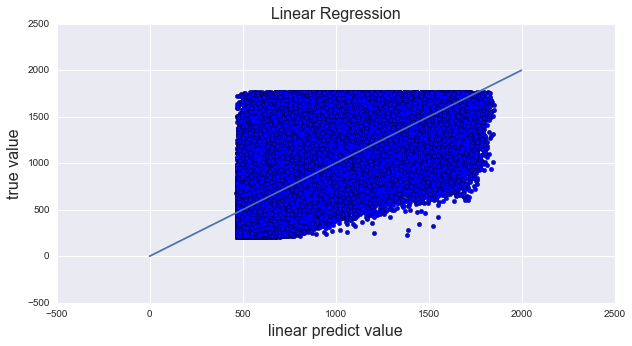

In [51]:
# Linear model 

from sklearn import linear_model

#fitting
linear_model = linear_model.LinearRegression()
linear_model.fit(X_train,y_train)
y_linear_fit = linear_model.predict(X_test)
print ('Linear model score :', linear_model.score(X_test,y_test))

# visualize 
plt.figure(figsize=(10,5))
plt.scatter(y_linear_fit,y_test, label = 'training points')
# hardcode here, just want a y=x line 
x = range(0,2000)
y = range(0,2000)
plt.plot(x, y)

# plot labels
plt.xlabel('linear predict value',fontsize=16);
plt.ylabel('true value',fontsize=16);
plt.title('Linear Regression',fontsize=16)
plt.show()


## 1-2) lasso regression

In [21]:
df_train_lasso_ = clean_data(df_train_)

In [62]:
lasso_feature = ['trip_duration', 
                 'vendor_id', 'passenger_count',
                 'direction','pickup_latitude',
                 'pickup_hour','pickup_month', 
                 'pickup_weekday','dropoff_hour',
                 'dropoff_month','distance_haversine',
                 'distance_manhattan']

In [63]:
from sklearn import linear_model
lasso_model = linear_model.Lasso(alpha=0.5)
reg_analysis(lasso_model,df_train_lasso_[lasso_feature])

cv model score =  [ 0.44535232  0.4434175   0.44116809  0.44485041]
Model score =  0.444371483552
RMSLE score =   0.392683012308


### 1-3) decision tree regression

In [24]:
df_train_tree_ = clean_data(df_train_)

In [81]:
tree_feature = ['trip_duration', 'vendor_id', 
                'passenger_count', 'pickup_longitude', 
                'pickup_latitude','dropoff_longitude',
                'dropoff_latitude','pickup_hour','pickup_month',
                'dropoff_hour','dropoff_month','direction' ,'avg_speed_h','avg_speed_m',
                'distance_haversine','pickup_weekday',
                'distance_manhattan']

In [82]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model = reg_analysis(tree_model,df_train_tree_[tree_feature])

cv model score =  [ 0.99989992  0.99990244  0.99989651  0.99990529]
Model score =  0.999899785542
RMSLE score =   0.00418884507109


In [27]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
reg_analysis(tree_model,df_train_tree_[tree_feature])

cv model score =  [ 0.42015153  0.41630617  0.41930769  0.41916538]
Model score =  0.419898467819
RMSLE score =   0.389767670242


### 1-4) random forest regression 

In [28]:
df_train_rf_ = clean_data(df_train_.head(1000))

In [77]:
rf_feature = ['trip_duration', 'vendor_id', 
                'passenger_count', 'pickup_longitude', 
                'pickup_latitude','dropoff_longitude',
                'dropoff_latitude','pickup_hour','pickup_month',
                'dropoff_hour','dropoff_month', 'avg_speed_h', 
                'distance_haversine','pickup_weekday',
                'distance_manhattan']

In [78]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
reg_analysis(rf_model,df_train_rf_[rf_feature])

cv model score =  [ 0.96423499  0.94158217  0.9543114   0.94536772]
Model score =  0.948171109181
RMSLE score =   0.0873070129975


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
reg_analysis(rf_model,df_train_rf_[rf_feature])

cv model score =  [ 0.48509132  0.50320005  0.40349278  0.41113094]
Model score =  0.392927919822
RMSLE score =   0.389840634202


### 1-5) xgboost

In [84]:
#df_train_xgb_ = clean_data(df_train_.head(1000))
#df_train_xgb_ = clean_data(df_train_)

In [86]:
#xgb_feature = ['trip_duration', #'distance_haversine',
#                  'distance_manhattan']

In [34]:
#import xgboost as xgb
#xgboost_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                           colsample_bytree=1, max_depth=7)

In [ ]:
#reg_analysis(xgboost_model,df_train_xgb_[xgb_feature])

In [ ]:
#xgboost_model.predict(X_test)

In [ ]:
#df_train_xgb_[xgb_feature]

### 1-x) logistic regression *** (need to fix )

In [ ]:
#logistic_feature = ['trip_duration', #'distance_haversine',
#       'distance_manhattan']
#df_train_logistic_ = clean_data(df_train_)
# only run 5000 data points here, since logistics start running slow when data >10k
#X_train, X_test, y_train, y_test = sample_split(df_train_logistic_[logistic_feature].head(5000))
#X_train, X_test, y_train, y_test = sample_split(df_train_logistics_[logistics_feature])
#from sklearn.linear_model import LogisticRegression
# http://www.jianshu.com/p/bbdeb356057e
# using all CPUs with n_jobs=-1
# process will run faster with solver='sag' 
#logistic_model = LogisticRegression(n_jobs=-1,tol = 0.1,solver='sag')
#reg_analysis(logistic_model,X_train, X_test, y_train, y_test)